# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '01'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="graupel"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 85334)
Dimensions without coordinates: cell
Data variables:
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    n_ice                          (cell) float32 ...
    z_ice                          (cell) float32 ...
    q_snow                         (cell) float32 ...
    n_snow                         (cell) float32 ...
    z_snow                         (cell) float32 ...
    q_rimedice                     (cell) float32 ...
    n_rimedice                     (cell) float32 ...
    z_rimedice                     (cell) float32 ...
    rime_rimedice                  (cell) float32 ...
    rvol_rimedice                  (cell) float32 ...
    liq_rim

# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_r  = xr.open_dataset(fname).q_rain.values
    n_r  = xr.open_dataset(fname).n_rain.values
    # process rates
    frze = xr.open_dataset(fname).frze_graupel_rain_mass.values  
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-18
    p_min = 1e-20
    # transform everything in log space
    q_r  = np.log(q_r, where=q_r>q_min, out=np.nan*q_r)
    n_r  = np.log(n_r, where=n_r>n_min, out=np.nan*q_r)
    frze = np.log(frze,where=frze>p_min,out=np.nan*frze)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_r, n_r, frze, temp, rho ]))
    dataset = dataset.T
    dataset.columns = [ 'q_r', 'n_r', 'frze', 'temp', 'rho' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_r          n_r         frze         temp          rho
count  9487.000000  9487.000000  9487.000000  9487.000000  9487.000000
mean    -10.885060     6.127335   -16.541162   254.751663     0.849173
std       4.748863     3.593119     3.965944     6.920063     0.102907
min     -34.217178   -13.053514   -42.733025   240.020004     0.613000
25%     -13.470147     4.278824   -18.846216   249.330002     0.768000
50%      -8.722915     7.096415   -15.809553   255.119995     0.849000
75%      -7.513772     8.676412   -13.619126   260.309998     0.927000
max      -3.764539    11.646791    -8.743836   270.260010     1.140000

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_r       n_r       frze        temp    rho
1 -8.314097  6.855482 -21.247431  268.350006  1.109
2 -8.264487  6.845903 -21.478065  268.010010  1.104
3 -8.215061  6.835843 -19.117731  267.679993  1.098
4 -8.165885  6.824143 -19.316696  267.350006  1.093
5 -8.116523  6.812820 -19.323635  267.010010  1.087

In [11]:
dataset_train.describe()

q_r          n_r         frze         temp          rho
count  6583.000000  6583.000000  6583.000000  6583.000000  6583.000000
mean    -10.893790     6.108118   -16.500280   254.681458     0.848115
std       4.727545     3.594956     3.967007     6.873111     0.102056
min     -34.217178   -13.053514   -42.733025   240.020004     0.613000
25%     -13.498627     4.270018   -18.848086   249.289993     0.768000
50%      -8.755754     7.089218   -15.754571   255.000000     0.848000
75%      -7.517797     8.653548   -13.558928   260.160004     0.925000
max      -3.764539    11.579443    -8.743836   270.260010     1.139000

In [12]:
dataset_test.describe()

q_r          n_r         frze         temp          rho
count  1475.000000  1475.000000  1475.000000  1475.000000  1475.000000
mean    -10.760368     6.156351   -16.620049   255.234390     0.856289
std       4.792872     3.611577     3.980046     7.018647     0.105474
min     -34.179626   -13.053514   -36.952297   240.360001     0.623000
25%     -13.090504     4.286219   -18.898962   249.715004     0.775000
50%      -8.565979     7.093056   -15.864244   255.990005     0.859000
75%      -7.451141     8.655077   -13.658763   260.845001     0.938000
max      -4.229010    11.646791    -8.854374   269.559998     1.115000

In [13]:
dataset_val.describe()

q_r          n_r         frze         temp          rho
count  1429.000000  1429.000000  1429.000000  1429.000000  1429.000000
mean    -10.973637     6.185882   -16.648075   254.578049     0.846700
std       4.801756     3.567124     3.945952     7.016207     0.103895
min     -33.579479   -12.542687   -37.295113   240.149994     0.624000
25%     -13.765712     4.373418   -18.750713   249.240005     0.765000
50%      -8.734423     7.122286   -15.967205   254.889999     0.842000
75%      -7.591689     8.794593   -13.763051   260.410004     0.928000
max      -3.984723    11.484145    -9.147703   269.829987     1.140000

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_r'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_r          n_r         frze         temp          rho
count  6137.000000  6137.000000  6137.000000  6137.000000  6137.000000
mean    -10.072937     6.663689   -15.850027   255.450623     0.858708
std       3.715336     3.003463     3.194225     6.432974     0.096813
min     -19.996264    -5.561682   -34.051460   240.639999     0.626000
25%     -12.073334     5.205209   -18.129169   250.559998     0.783000
50%      -8.596128     7.300378   -15.362918   255.679993     0.859000
75%      -7.425755     8.755728   -13.424436   260.540009     0.930000
max      -3.764539    11.579443    -8.743836   270.260010     1.139000

In [17]:
dataset_test.describe()

q_r          n_r         frze         temp          rho
count  1375.000000  1375.000000  1375.000000  1375.000000  1375.000000
mean     -9.900990     6.730871   -15.970717   256.064758     0.867818
std       3.667931     2.963846     3.224369     6.497263     0.099275
min     -19.809137    -4.386637   -30.416998   240.820007     0.623000
25%     -11.709608     5.214963   -18.355842   251.235001     0.794000
50%      -8.436987     7.309299   -15.574424   256.609985     0.870000
75%      -7.372162     8.769427   -13.566314   261.279999     0.942000
max      -4.229010    11.646791    -8.854374   269.559998     1.115000

### Pairplot

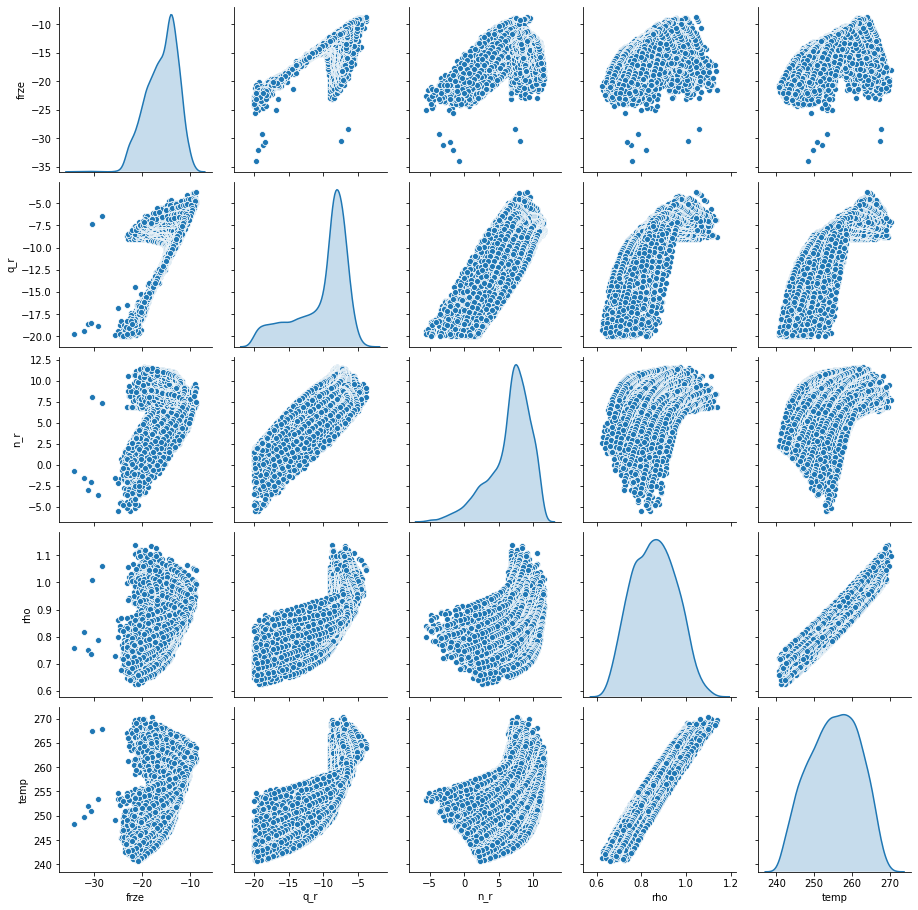

In [18]:
sns.pairplot(dataset_train[["frze","q_r","n_r","rho","temp"]], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['rho'], axis=1)
#train_dataset2 = train_dataset2.drop(['temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['temp'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['rho'], axis=1)
#test_dataset2 = test_dataset2.drop(['temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['temp'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['rho'], axis=1)
#val_dataset2 = val_dataset2.drop(['temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['temp'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("frze")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean       std         min         25%         50%  \
q_r   6137.0  -10.072937  3.715336  -19.996264  -12.073334   -8.596128   
n_r   6137.0    6.663689  3.003463   -5.561682    5.205209    7.300378   
temp  6137.0  255.450623  6.432974  240.639999  250.559998  255.679993   

             75%         max  
q_r    -7.425755   -3.764539  
n_r     8.755728   11.579443  
temp  260.540009  270.260010

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("frze")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_r   6137.0  -10.072937  3.715336  -19.996264  -12.073334   -8.596128   
n_r   6137.0    6.663689  3.003463   -5.561682    5.205209    7.300378   
temp  6137.0  255.450623  6.432974  240.639999  250.559998  255.679993   
rho   6137.0    0.858708  0.096813    0.626000    0.783000    0.859000   

             75%         max  
q_r    -7.425755   -3.764539  
n_r     8.755728   11.579443  
temp  260.540009  270.260010  
rho     0.930000    1.139000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['frze']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_labels.describe()

frze
count  6137.000000
mean    -15.850027
std       3.194225
min     -34.051460
25%     -18.129169
50%     -15.362918
75%     -13.424436
max      -8.743836

In [30]:
train_dataset1.describe()

q_r          n_r         temp
count  6137.000000  6137.000000  6137.000000
mean    -10.072937     6.663689   255.450623
std       3.715336     3.003463     6.432974
min     -19.996264    -5.561682   240.639999
25%     -12.073334     5.205209   250.559998
50%      -8.596128     7.300378   255.679993
75%      -7.425755     8.755728   260.540009
max      -3.764539    11.579443   270.260010

In [31]:
train_dataset2.describe()

q_r          n_r         temp          rho
count  6137.000000  6137.000000  6137.000000  6137.000000
mean    -10.072937     6.663689   255.450623     0.858708
std       3.715336     3.003463     6.432974     0.096813
min     -19.996264    -5.561682   240.639999     0.626000
25%     -12.073334     5.205209   250.559998     0.783000
50%      -8.596128     7.300378   255.679993     0.859000
75%      -7.425755     8.755728   260.540009     0.930000
max      -3.764539    11.579443   270.260010     1.139000

### Normalize the features

In [32]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)

In [33]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean       std       min       25%       50%       75%  \
q_r   6137.0  3.562526e-06  1.000002 -2.670909 -0.538416  0.397490  0.712501   
n_r   6137.0  3.212454e-07  1.000000 -4.070425 -0.485599  0.211985  0.696542   
temp  6137.0 -4.800877e-05  0.999998 -2.302298 -0.760243  0.035655  0.791140   

           max  
q_r   1.697935  
n_r   1.636695  
temp  2.302106

In [34]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
q_r   6137.0  3.562526e-06  1.000002 -2.670909 -0.538416  0.397490  0.712501   
n_r   6137.0  3.212454e-07  1.000000 -4.070425 -0.485599  0.211985  0.696542   
temp  6137.0 -4.800877e-05  0.999998 -2.302298 -0.760243  0.035655  0.791140   
rho   6137.0  7.146322e-06  0.999997 -2.403676 -0.781998  0.003019  0.736389   

           max  
q_r   1.697935  
n_r   1.636695  
temp  2.302106  
rho   2.895184

### Normalize the labels

In [35]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std       min        25%        50%        75%  \
frze  6137.0 -15.850027  3.194225 -34.05146 -18.129169 -15.362918 -13.424436   

           max  
frze -8.743836

In [36]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [37]:
DNNstring='16x16x16'

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [38]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(3,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [40]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.87837577],
       [-0.8781478 ],
       [-0.87792736],
       [-0.8777094 ],
       [-0.8774793 ],
       [-0.87702596],
       [-0.8768062 ],
       [-0.87658095],
       [-0.8763522 ],
       [-0.87612766]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [41]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [42]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.9804,  mae:0.8237,  mse:0.9804,  val_loss:0.8612,  val_mae:0.7638,  val_mse:0.8612,  
.............................................................................................

Text(0, 0.5, 'MAE')

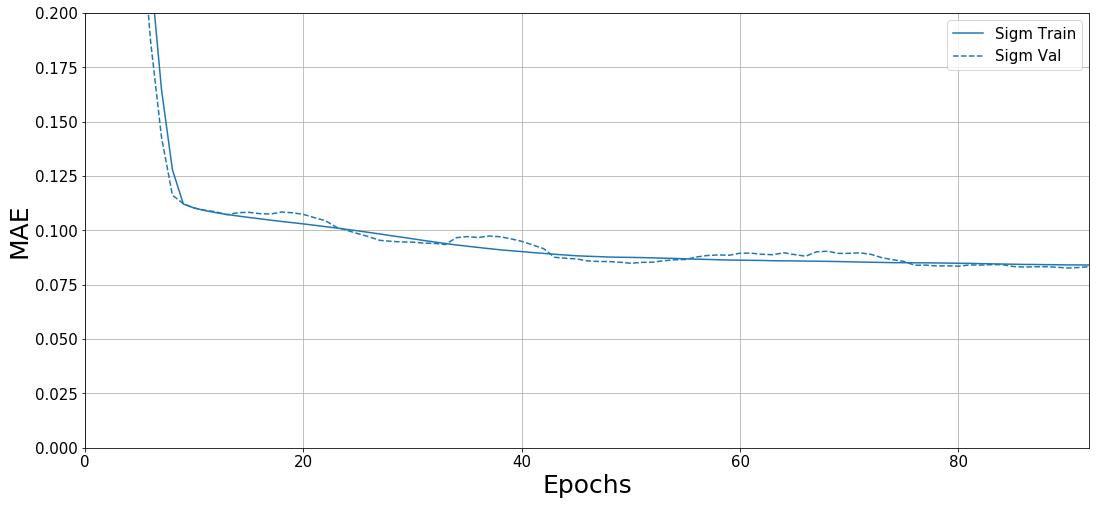

In [43]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.2])
plt.ylabel('MAE')

In [45]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.1500,  mae:0.8907,  mse:1.1500,  val_loss:0.8445,  val_mae:0.7572,  val_mse:0.8445,  
....................................................................................................
Epoch: 100, loss:0.0268,  mae:0.0832,  mse:0.0268,  val_loss:0.0234,  val_mae:0.0796,  val_mse:0.0234,  
..............................

Text(0, 0.5, 'MAE')

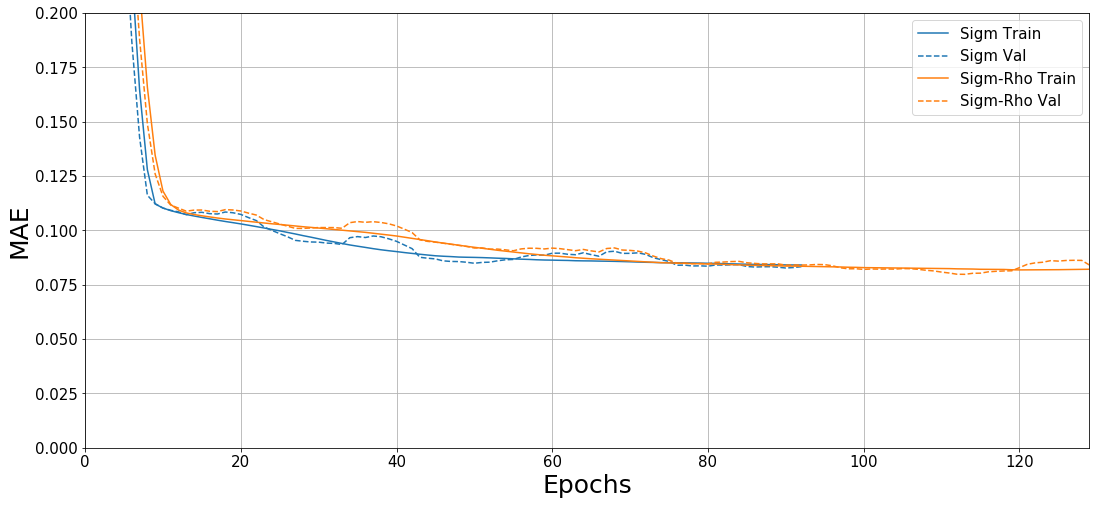

In [46]:
histories['sigm-rho'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.2])
plt.ylabel('MAE')

In [47]:
activ = "ReLU"
model3 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3339,  mae:0.4281,  mse:0.3339,  val_loss:0.0894,  val_mae:0.2089,  val_mse:0.0894,  
................................................

Text(0, 0.5, 'MAE')

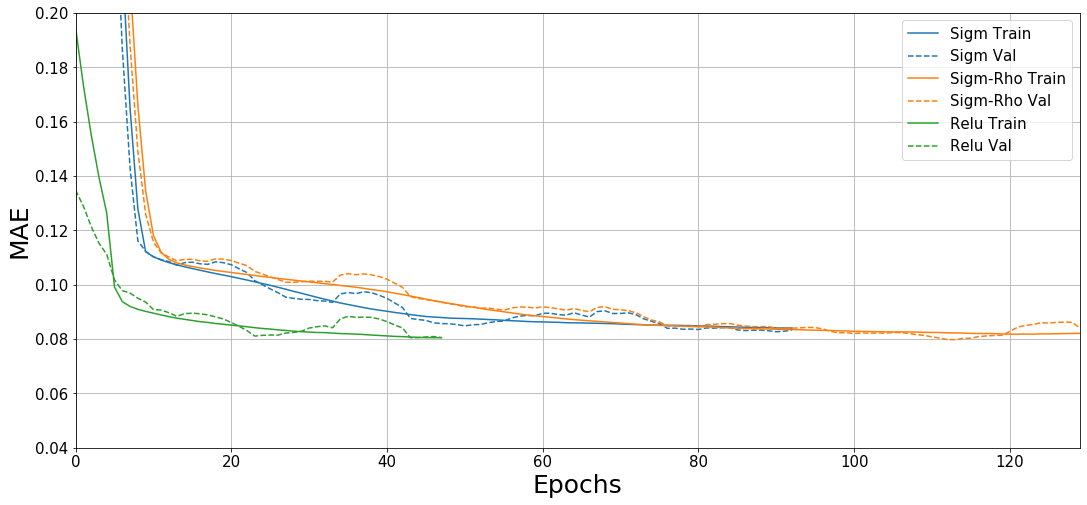

In [48]:
histories['ReLU'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.2])
plt.ylabel('MAE')

In [49]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3201,  mae:0.4171,  mse:0.3201,  val_loss:0.0964,  val_mae:0.2112,  val_mse:0.0964,  
......................................

Text(0, 0.5, 'MAE')

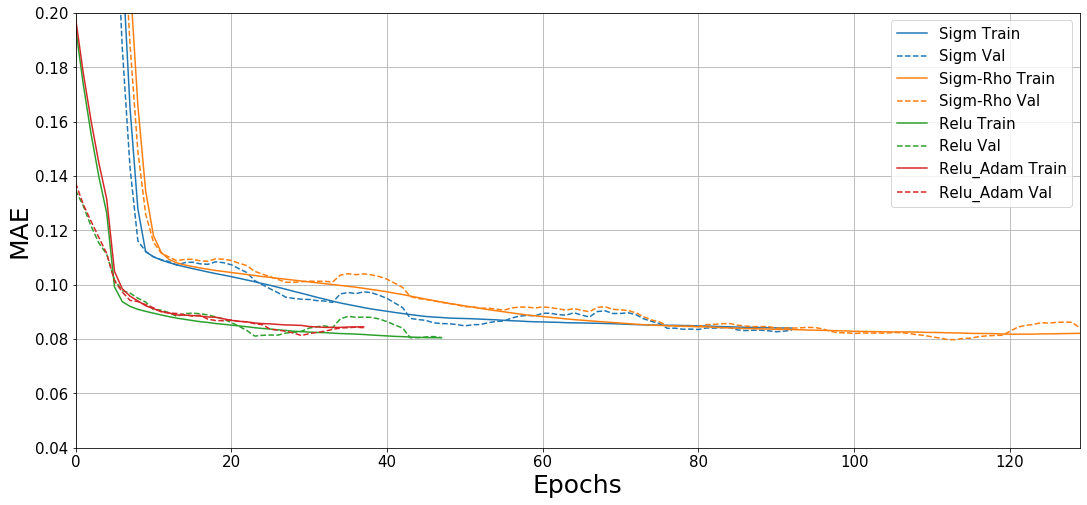

In [50]:
histories['ReLU_Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.2])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

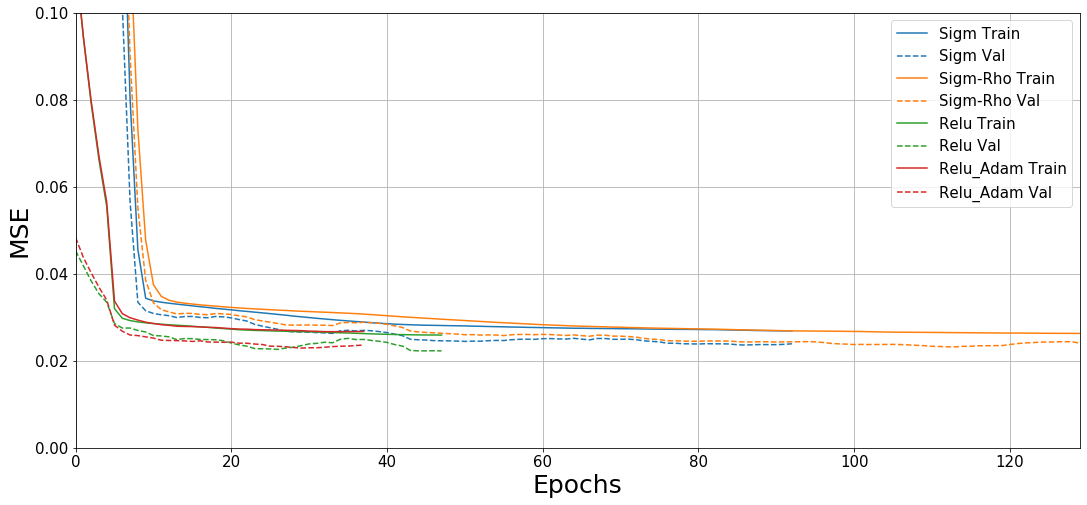

In [51]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.0, 0.1])
plt.ylabel('MSE')

In [52]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

1375/1375 - 0s - loss: 0.0531 - mae: 0.0931 - mse: 0.0531
Testing set for model 1, Mean Abs Error:    0.09307


In [53]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

1375/1375 - 0s - loss: 0.0517 - mae: 0.0903 - mse: 0.0517
Testing set for model 3, Mean Abs Error:              0.09028


In [54]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

1375/1375 - 0s - loss: 0.0532 - mae: 0.0949 - mse: 0.0532
Testing set for model 4, Mean Abs Error:              0.09489


In [55]:
mae = [ mae1, mae3, mae4 ]
mae

[0.093067765, 0.090278655, 0.094885595]

In [56]:
mse = [ mse1, mse3, mse4 ]
mse

[0.053068504, 0.051663604, 0.053150102]

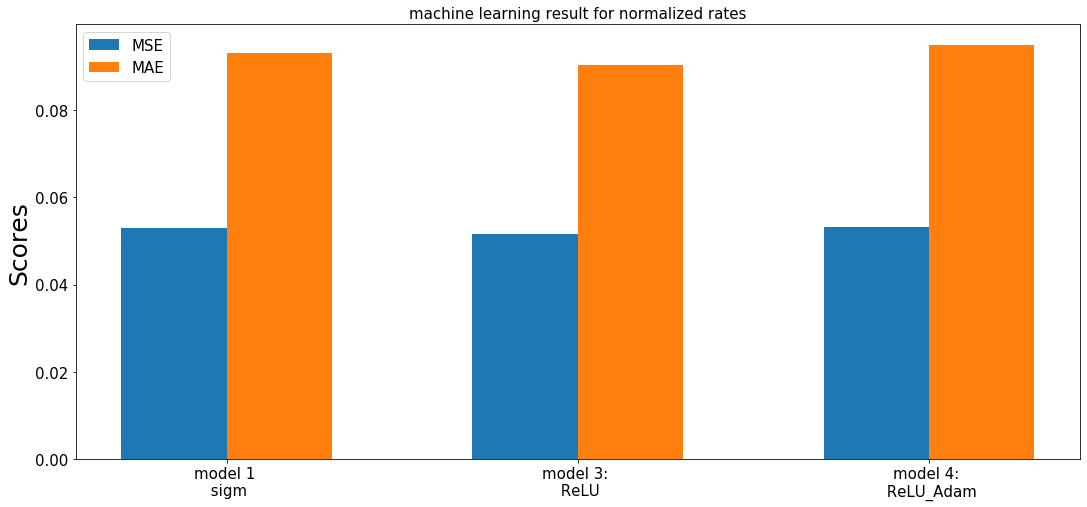

In [57]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1 \n sigm',
 'model 3: \n ReLU',
 'model 4: \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [58]:
test_true_liq  = np.exp(test_labels.pop('frze'))

In [59]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [60]:
labels = [ "frze" ]

p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=labels)

In [61]:
p1.describe()

frze
count  1375.000000
mean     -0.026680
std       0.982660
min      -2.365982
25%      -0.760763
50%       0.078448
75%       0.733274
max       2.001518

In [62]:
train_labels_stats

count       mean       std       min        25%        50%        75%  \
frze  6137.0 -15.850027  3.194225 -34.05146 -18.129169 -15.362918 -13.424436   

           max  
frze -8.743836

In [63]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [64]:
test_predict1.describe()

frze
count  1.375000e+03
mean   2.343826e-06
std    6.449657e-06
min    6.827298e-11
25%    1.150977e-08
50%    1.679756e-07
75%    1.360327e-06
max    7.816200e-05

In [65]:
np.exp(test_dataset1.head())

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


q_r         n_r  temp
6   0.000314  898.632141   inf
16  0.000508  767.703064   inf
19  0.000581  720.488098   inf
38  0.000183  165.152954   inf
42  0.000044   58.148090   inf

In [66]:
test_predict1.head()

frze
0  4.679642e-09
1  1.234707e-07
2  3.525608e-07
3  5.677154e-06
4  2.028513e-06

In [67]:
test_dataset2.head()

q_r       n_r        temp    rho
6   -8.067165  6.800874  266.679993  1.081
16  -7.584950  6.643403  263.339996  1.027
19  -7.451016  6.579929  262.339996  1.011
38  -8.604414  5.106872  256.010010  0.914
42 -10.020451  4.062993  254.669998  0.894

In [68]:
test_predict1_liq   = test_predict1['frze']

In [69]:
p4 = pd.DataFrame(data=model4.predict(normed_test_data2), columns=labels)

test_predict4 = np.exp(backtransform(p4,train_labels_stats))

test_predict4_liq   = test_predict4['frze']

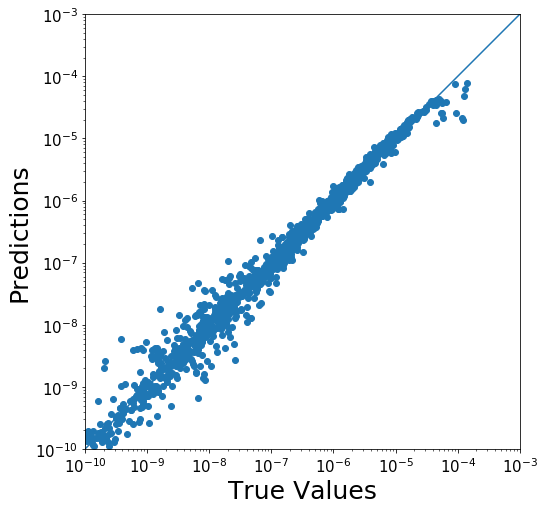

In [70]:
amin, amax = 1e-10, 1e-3

a = plt.axes(aspect='equal')
plt.scatter(test_true_liq, test_predict1_liq)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

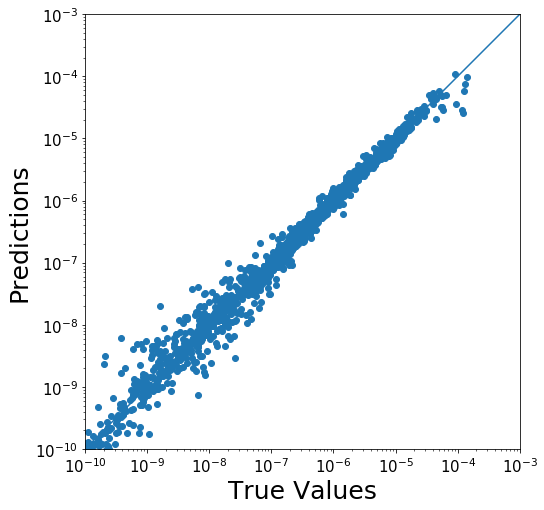

In [71]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_liq, test_predict4_liq)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [72]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'01'

In [73]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [74]:
train_stats1

count        mean       std         min         25%         50%  \
q_r   6137.0  -10.072937  3.715336  -19.996264  -12.073334   -8.596128   
n_r   6137.0    6.663689  3.003463   -5.561682    5.205209    7.300378   
temp  6137.0  255.450623  6.432974  240.639999  250.559998  255.679993   

             75%         max  
q_r    -7.425755   -3.764539  
n_r     8.755728   11.579443  
temp  260.540009  270.260010

In [75]:
features = 'q_r, n_r, temp'
labels   = 'frze'
filename = 'saved_model_v2/frze_rain_model1_'+version+'.nc'
logtransform = np.array([True, True, False], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/frze_rain_model1_01.nc
  Features:   q_r, n_r, temp
  Labels:     frze
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (3, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [76]:
features = 'q_r, n_r, temp, rho'
filename = 'saved_model_v2/frze_rain_model3_'+version+'.nc'
logtransform = np.array([True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/frze_rain_model3_01.nc
  Features:   q_r, n_r, temp, rho
  Labels:     frze
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [77]:
filename = 'saved_model_v2/frze_rain_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/frze_rain_model4_01.nc
  Features:   q_r, n_r, temp, rho
  Labels:     frze
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
